Reference:

+ https://towardsdatascience.com/explainable-ai-xai-a-guide-to-7-packages-in-python-to-explain-your-models-932967f0634b

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Tablular Data

## Load Data and Train Model

In [2]:
# Read the DataFrame, first using the feature data
data = load_breast_cancer() 
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add a target column, and fill it with the target data
df['target'] = data.target
print(df['target'].value_counts())

# Show the first five rows
df.head()

1    357
0    212
Name: target, dtype: int64


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  target  
0          0.4601                  0.11890       0  
1          0.2750                  0.08902       0  
2          0.3613                  0.08758       0  
3          0.6638                  0.17300       0  
4          0.2364                  0.07678       0  

[5 rows x 31 columns]

In [3]:
y=df['target'].to_frame() # define Y
X=df[df.columns.difference(['target'])] # define X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # create train and test

# build model - Xgboost
xgb_mod=xgb.XGBClassifier(random_state=42,gpu_id=0) # build classifier
xgb_mod=xgb_mod.fit(X_train,y_train.values.ravel()) 

# make prediction and check model accuracy 
y_pred = xgb_mod.predict(X_test)

# Performance
accuracy = accuracy_score(y_test, y_pred)
accuracy

[00:44:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/zhiyuwang/opt/anaconda3/envs/auto_ml/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9736842105263158

## LIME

In [4]:
import lime
import lime.lime_tabular

In [5]:
explainer = lime.lime_tabular.LimeTabularExplainer(  # Input data is tabular
    X_test.to_numpy(),                 # training data: numpy 2d array
    mode = 'classification',           # classification or regression
    feature_names=X_test.columns,      # column names of training data
    categorical_features=None,         # categorical features have to be separatedly specified
    categorical_names=None,
    class_names=['0', '1'],
    verbose=True) 

In [6]:
explainer = lime.lime_tabular.LimeTabularExplainer(  # Input data is tabular
    X_test.to_numpy(),                 # training data: numpy 2d array
    mode = 'classification',           # classification or regression
    feature_names=X_test.columns,      # column names of training data
    categorical_features=None,         # categorical features have to be separatedly specified
    categorical_names=None,
    class_names=['0', '1'],
    verbose=True) 

# LIME cannot do batch explaination
exp = explainer.explain_instance(
    X_test.to_numpy()[2],  # input: data row, need to be 1d numpy array or scipy.sparse matrix
    xgb_mod.predict_proba, # prediction function
    num_features=10,       # maximum number of features present in explanation
    num_samples=1000       # size of the neighborhood to learn the linear model
)

exp.as_list()

Intercept 0.8095464162253976
Prediction_local [0.1415528]
Right: 0.00048357475


[('mean concave points > 0.07', -0.19846039057265896),
 ('worst concavity > 0.37', -0.17564987998425907),
 ('14.95 < worst radius <= 19.70', -0.07254234501229977),
 ('symmetry error <= 0.01', -0.07177626556157958),
 ('681.20 < worst area <= 1211.00', -0.06777267787054031),
 ('0.01 < concave points error <= 0.01', -0.06733825824922997),
 ('mean smoothness > 0.11', -0.06307763709828915),
 ('2.29 < perimeter error <= 3.68', 0.05743027384397883),
 ('25.79 < worst texture <= 30.04', -0.056895786538770574),
 ('16.22 < mean texture <= 19.54', 0.048089351436550846)]

### LIME Values

In [7]:
# LIME cannot do batch explaination
exp = explainer.explain_instance(
    X_test.to_numpy()[2],  # input: data row, need to be 1d numpy array or scipy.sparse matrix
    xgb_mod.predict_proba, # prediction function
    num_features=10,       # maximum number of features present in explanation
    num_samples=1000       # size of the neighborhood to learn the linear model
)

Intercept 0.793695949825779
Prediction_local [0.08593979]
Right: 0.00048357475


In [8]:
exp.as_list()

[('worst concavity > 0.37', -0.16224289556633067),
 ('mean concave points > 0.07', -0.16167582382178106),
 ('mean smoothness > 0.11', -0.13903968770539768),
 ('681.20 < worst area <= 1211.00', -0.0919260176686101),
 ('23.21 < area error <= 51.99', -0.08551626419822893),
 ('symmetry error <= 0.01', -0.07325249721712698),
 ('25.79 < worst texture <= 30.04', -0.06032336347738379),
 ('16.22 < mean texture <= 19.54', 0.059552004397516727),
 ('0.01 < smoothness error <= 0.01', 0.05851086067711313),
 ('97.16 < worst perimeter <= 129.18', -0.051842478129431845)]

In [9]:
col1 = [i[0] for i in exp.as_list()]
col2 = [i[1] for i in exp.as_list()]
tmp_tbl = pd.DataFrame({'Column': col1, 'LIME': col2})
tmp_tbl

Column      LIME
0             worst concavity > 0.37 -0.162243
1         mean concave points > 0.07 -0.161676
2             mean smoothness > 0.11 -0.139040
3     681.20 < worst area <= 1211.00 -0.091926
4        23.21 < area error <= 51.99 -0.085516
5             symmetry error <= 0.01 -0.073252
6     25.79 < worst texture <= 30.04 -0.060323
7      16.22 < mean texture <= 19.54  0.059552
8    0.01 < smoothness error <= 0.01  0.058511
9  97.16 < worst perimeter <= 129.18 -0.051842

### Visualization

In [10]:
exp.show_in_notebook(show_table=True)

## SHAP

In [11]:
import shap

In [12]:
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value  # average of the classifier/model output over X
print(X.shape, shap_values.shape, expected_value)

(569, 30) (569, 30) 1.1031655


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### SHAP Values

In [13]:
tmp = pd.DataFrame(shap_values, columns=X.columns)
tmp.head()

area error  compactness error  concave points error  concavity error  \
0   -0.895708           0.299737             -0.226916        -0.019842   
1   -0.955774          -0.416848             -0.215945        -0.022400   
2   -0.916175           0.520153             -0.215945        -0.019842   
3    0.052190           0.549478             -0.233183        -0.018551   
4   -1.032812           0.325605             -0.226916        -0.019842   

   fractal dimension error  mean area  mean compactness  mean concave points  \
0                 0.015816  -0.374805          0.115417            -1.818511   
1                 0.015816  -0.273807          0.115631            -1.858436   
2                 0.031735  -0.491877          0.115417            -1.547813   
3                 0.033767   0.190525          0.115417            -2.264937   
4                 0.015816  -0.374805          0.115417            -1.926082   

   mean concavity  mean fractal dimension  ...  worst area  worst compactness  \
0       -0.102148                0.121670  ...   -0.853403          -0.055524   
1       -0.102148               -0.057986  ...   -0.864248           0.005877   
2       -0.102148               -0.057986  ...   -0.881353           0.005877   
3       -0.102148                0.120450  ...    0.976444          -0.122048   
4       -0.102148               -0.053485  ...   -0.883690           0.005877   

   worst concave points  worst concavity  worst fractal dimension  \
0             -1.627281        -0.462996                      0.0   
1             -1.789013        -0.504077                      0.0   
2             -1.432106        -0.591773                      0.0   
3             -2.331061        -0.517430                      0.0   
4             -1.590493        -0.483490                      0.0   

   worst perimeter  worst radius  worst smoothness  worst symmetry  \
0        -0.924430     -0.446941         -0.372382       -0.472766   
1        -1.215814     -0.768139          0.148908        0.187581   
2        -1.067221     -0.771605         -0.383692       -0.472766   
3         0.725177      0.038276         -0.673403       -0.543986   
4        -1.117915     -0.522635         -0.043966        0.339772   

   worst texture  
0       1.508112  
1       0.266231  
2      -0.153996  
3      -0.442937  
4       1.634597  

[5 rows x 30 columns]

### Visualization

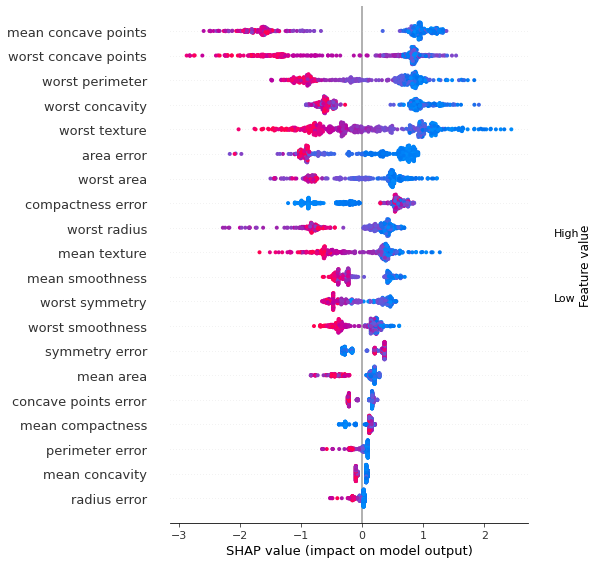

In [14]:
# Generate summary dot plot
shap.summary_plot(shap_values, X,title="SHAP summary plot") 

In [15]:
# Generate summary bar plot 
shap.summary_plot(shap_values, X,plot_type="bar") 

In [16]:
# Generate waterfall plot: single prediction
shap.plots._waterfall.waterfall_legacy(expected_value,
                                       shap_values[79],
                                       features=X.loc[79, :],
                                       feature_names=X.columns,
                                       max_display=15,
                                       show=True)

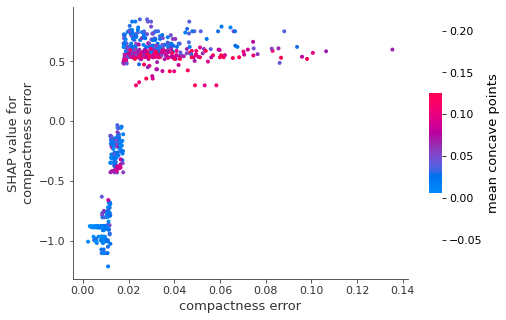

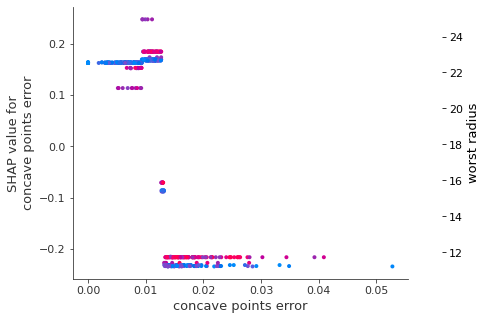

In [17]:
# Generate multiple dependence plots
for name in X_train.columns[:3]:
     shap.dependence_plot(name, shap_values, X)
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")

In [18]:
# Generate force plot - Multiple rows 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], X.iloc[:100,:])

In [19]:
# Generate force plot - Single
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

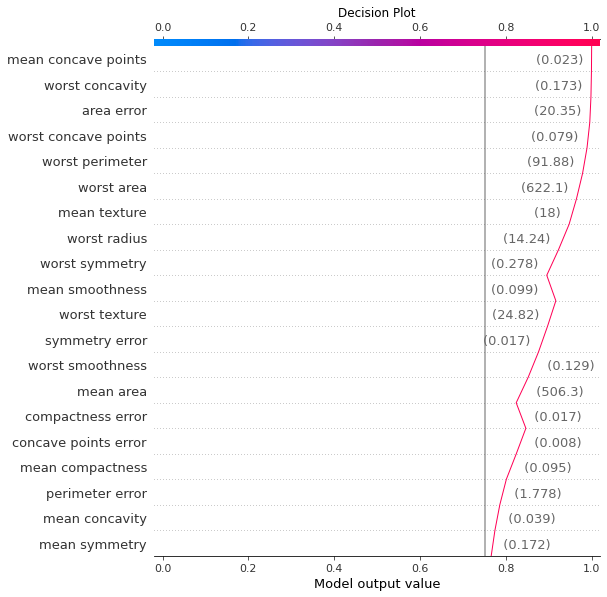

In [20]:
# Generate Decision plot
shap.decision_plot(expected_value,
                   shap_values[79],
                   link='logit',
                   features=X.loc[79, :],
                   feature_names=(X.columns.tolist()),
                   show=True,
                   title="Decision Plot")

# Multiple Output

## Load Data and Train Model

In [21]:
from sklearn.datasets import make_regression
from keras.models import Sequential
from keras.layers import Dense

In [22]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=7, n_targets=5, random_state=0)

# Convert the data into Pandas Dataframes for easier maniplution and keeping stored column names
# Create feature column names
feature_cols = ['feature_01', 'feature_02', 'feature_03', 'feature_04',
              'feature_05', 'feature_06', 'feature_07', 'feature_08',
              'feature_09', 'feature_10']

df_features = pd.DataFrame(data = X, columns = feature_cols)

# Create lable column names and dataframe
label_cols = ['labels_01', 'labels_02', 'labels_03', 'labels_04', 'labels_05']

df_labels = pd.DataFrame(data = y, columns = label_cols)

In [23]:
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(y.shape[1], kernel_initializer='he_uniform'))
model.compile(loss='mae', optimizer='adam')

2022-07-20 00:45:05.521373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
model.fit(X, y, verbose=0, epochs=100)
model.evaluate(x = X, y = y)

32/32 [==============================] - 0s 776us/step - loss: 12.9615


12.961504936218262

In [25]:
model.predict(X[0:1,:])

1/1 [==============================] - 0s 62ms/step


array([[   9.22065,  -67.67698,  -70.96947,  -83.22277, -123.6363 ]],
      dtype=float32)

In [26]:
model.predict(X[0:1, :])[0,1].reshape(-1, )

1/1 [==============================] - 0s 17ms/step


array([-67.67698], dtype=float32)

## LIME

In [27]:
explainer = lime.lime_tabular.LimeTabularExplainer(  # Input data is tabular
    X,                                 # training data: numpy 2d array
    mode = 'regression',               # classification or regression
    feature_names=feature_cols,        # column names of training data
    categorical_features=None,         # categorical features have to be separatedly specified
    categorical_names=None,
    verbose=True) 

### LIME Values

In [28]:
# LIME cannot do multi-label explaination
def LIME_multilabel_instance(label_index, X_input, model):
    
    def make_model_single_output(label_index):
        def model_single_output(input_):
            ys = model.predict(input_)
            return ys[:,label_index].reshape(-1,)
        return model_single_output
    
    exp = explainer.explain_instance(
        X_input,  # input: data row, need to be 1d numpy array or scipy.sparse matrix
        make_model_single_output(label_index), # prediction function
        num_features=10,       # maximum number of features present in explanation
        num_samples=80       # size of the neighborhood to learn the linear model
    )
    
    return exp

In [29]:
exp = LIME_multilabel_instance(label_index=0, X_input=X[2], model=model)

3/3 [==============================] - 0s 2ms/step
Intercept -57.0206650961062
Prediction_local [102.32379614]
Right: 222.24533


In [30]:
exp.as_list()

[('feature_08 > 0.62', 132.92328895294077),
 ('feature_10 > 0.67', 53.13079761013012),
 ('feature_04 > 0.63', -51.6772333547355),
 ('-0.71 < feature_09 <= -0.08', -48.27582684385066),
 ('-0.62 < feature_02 <= -0.01', -48.266576243613706),
 ('feature_05 > 0.64', 47.7729682112812),
 ('-0.06 < feature_06 <= 0.60', 40.96939761451247),
 ('-0.55 < feature_01 <= 0.05', 20.408506530612065),
 ('-0.76 < feature_03 <= -0.05', 20.039192005643255),
 ('feature_07 > 0.64', -7.680053243727027)]

In [31]:
col1 = [i[0] for i in exp.as_list()]
col2 = [i[1] for i in exp.as_list()]
tmp_tbl = pd.DataFrame({'Column': col1, 'LIME': col2})
tmp_tbl

Column        LIME
0            feature_08 > 0.62  132.923289
1            feature_10 > 0.67   53.130798
2            feature_04 > 0.63  -51.677233
3  -0.71 < feature_09 <= -0.08  -48.275827
4  -0.62 < feature_02 <= -0.01  -48.266576
5            feature_05 > 0.64   47.772968
6   -0.06 < feature_06 <= 0.60   40.969398
7   -0.55 < feature_01 <= 0.05   20.408507
8  -0.76 < feature_03 <= -0.05   20.039192
9            feature_07 > 0.64   -7.680053

### Visualization

In [32]:
exp.show_in_notebook(show_table=True)

## SHAP

In [33]:
explainer = shap.KernelExplainer( # explain output of any model
    model = model.predict, data = X[:50,:], link = "identity"
)

2/2 [==============================] - 0s 2ms/step


### SHAP Values

In [34]:
tmp = explainer.shap_values(X = X[:2,:], nsamples = 100)
print(len(tmp), tmp[0].shape)

  0%|          | 0/2 [00:00<?, ?it/s]

157/157 [==============================] - 0s 663us/step
5 (2, 10)


In [35]:
tmp_tbl = pd.DataFrame()
for i in range(len(label_cols)):
    tmp0 = pd.DataFrame(tmp[i], columns=feature_cols)
    tmp0['target'] = label_cols[i]
    tmp0['index'] = [0, 1]
    tmp_tbl = pd.concat([tmp_tbl, tmp0], ignore_index=True)

tmp_tbl = tmp_tbl[['target', 'index'] + tmp_tbl.columns.tolist()[:-2]]    
tmp_tbl

target  index  feature_01  feature_02  feature_03  feature_04  \
0  labels_01      0    0.000000   23.353290         0.0  -11.614557   
1  labels_01      1    0.000000   48.849619         0.0    0.000000   
2  labels_02      0    0.000000   30.183702         0.0  -34.727158   
3  labels_02      1    0.000000   73.898729         0.0    0.000000   
4  labels_03      0    0.000000   24.842088         0.0  -51.895057   
5  labels_03      1    0.000000   62.941999         0.0    0.000000   
6  labels_04      0    0.000000    0.000000         0.0  -98.310929   
7  labels_04      1    0.000000    0.000000         0.0    0.000000   
8  labels_05      0    0.000000   14.383617         0.0 -117.693419   
9  labels_05      1    4.992105   36.661920         0.0    0.000000   

   feature_05  feature_06  feature_07  feature_08  feature_09  feature_10  
0    0.000000  -84.195747         0.0  -37.329555  123.950170  -10.239527  
1    0.000000   85.668465         0.0 -131.230185  -78.005972  -25.842906  
2  -12.522548  -72.562723         0.0  -23.218628   75.766876  -26.454125  
3   29.655667   76.811792         0.0  -93.498018  -48.123430  -66.296232  
4  -10.938738  -50.977317         0.0  -25.243839   73.478931  -31.885778  
5   27.089494   57.845877         0.0  -97.494298  -45.226715  -79.777965  
6   -6.679375  -28.433663         0.0  -29.652605  110.237904  -44.305032  
7    0.000000    0.000000         0.0  -86.365471  -50.193495  -92.330089  
8  -15.802213  -15.000240         0.0  -32.762157   52.421333  -11.894319  
9   36.479248   15.148896         0.0 -112.955957  -32.298353  -28.569706